In [58]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

In [97]:
#Loading the data
data = pd.read_csv('/Users/ash/Downloads/anonymized.csv')

#Clean the date in a more processable format
def clean_date(obj): 
    obj = str(obj)
    date = obj[:2]
    year = obj[-4:]
    month = obj[2:-4]
    if month == 'Jan': 
        month = 1
    elif month == 'Feb': 
        month = 2
    elif month == 'Mar': 
        month = 3
    elif month == 'Apr': 
        month = 4
    elif month == 'May': 
        month = 5
    elif month == 'Jun': 
        month = 6
    elif month == 'Jul': 
        month = 7
    elif month == 'Aug': 
        month = 8
    elif month == 'Sep': 
        month = 9
    elif month == 'Oct': 
        month = 10
    elif month == 'Nov': 
        month = 11
    elif month == 'Dec': 
        month = 12
    return date+'/'+str(month)+'_'+year

data['Date'] = data['Date'].apply(clean_date)
dumb = pd.DataFrame(data['Date'].str.split('/',2).tolist())
data = pd.concat([data, dumb], axis=1)

data.columns = ['Date', 'Amount', 'Day', 'Month-Year']
data = data.drop(columns=['Date'])
data.head()

,Amount,Day,Month-Year
0,"54,241.35",25,5_2016
1,"54,008.83",29,5_2017
2,"54,008.82",30,6_2017
3,"52,704.37",05,1_2017
4,"52,704.36",23,2_2017


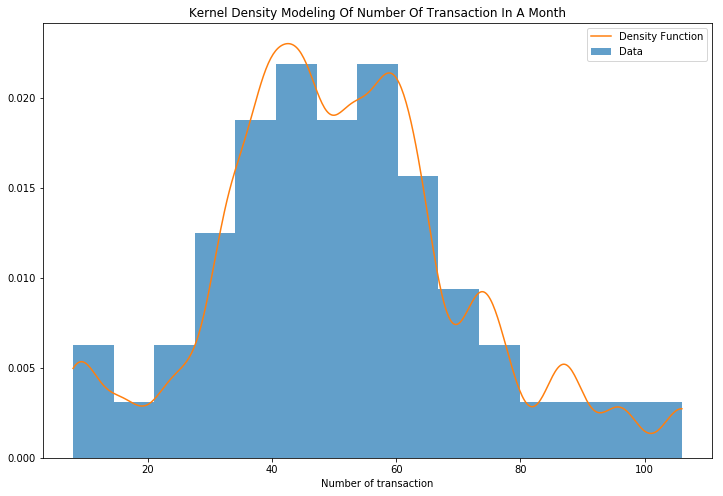

In [107]:
#Density model of the number of transaction in a month

#Count the number of transaction by pandas
hist_data = np.array(data['Month-Year'].value_counts())

#Model the counts by Gaussians
kde_1 = KernelDensity(kernel='gaussian', bandwidth=3).fit(hist_data.reshape(-1,1))

#Create density model
x = np.linspace(min(hist_data),max(hist_data), 500).reshape(-1, 1)
y = np.exp(kde_1.score_samples(x))

plt.figure(figsize=(12,8))
plt.hist(hist_data, density=True, bins=15, label='Data', alpha=0.7)
plt.plot(x, y, label='Density Function')
plt.legend()
plt.xlabel('Number of transaction')
plt.title('Kernel Density Modeling Of Number Of Transaction In A Month')
plt.show()

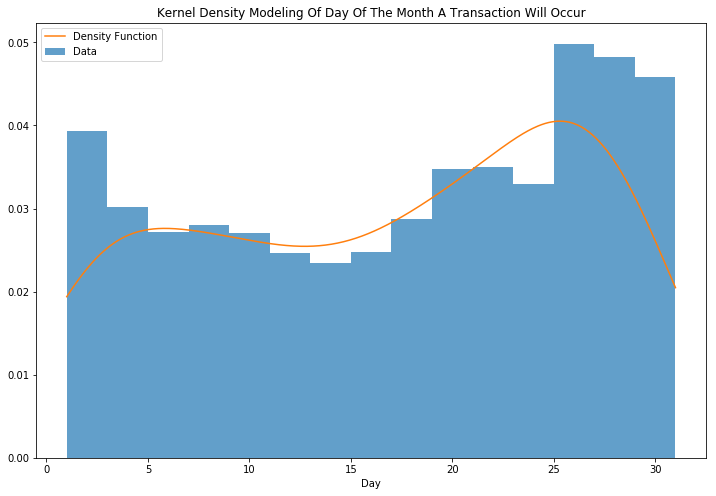

In [114]:
#Density model of the number of transaction in a day

hist_data = np.array(data['Day'], dtype=float)

kde_2 = KernelDensity(kernel='gaussian', bandwidth=3).fit(hist_data.reshape(-1,1))
x = np.linspace(min(hist_data),max(hist_data), 500).reshape(-1, 1)
y = np.exp(kde_2.score_samples(x))

plt.figure(figsize=(12,8))
plt.hist(hist_data, density=True, bins=15, label='Data', alpha=0.7)
plt.plot(x, y, label='Density Function')
plt.legend()
plt.xlabel('Day')
plt.title('Kernel Density Modeling Of Day Of The Month A Transaction Will Occur')
plt.show()

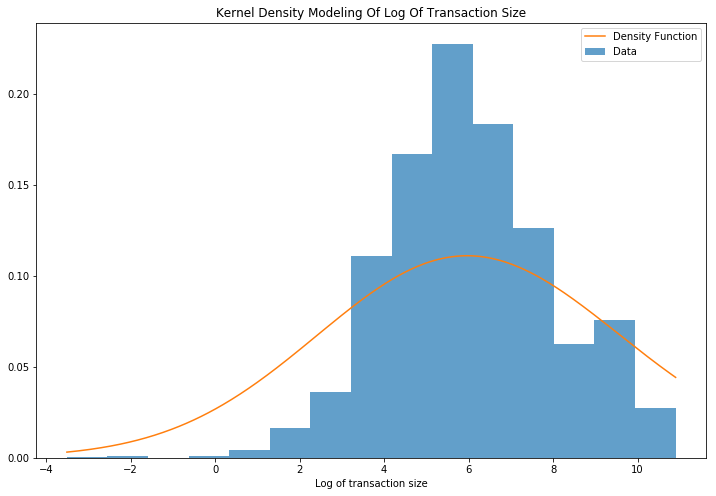

In [110]:
#Density model of the transaction size

hist_data = np.array(np.log(np.absolute(data['Amount'])))

kde_3 = KernelDensity(kernel='gaussian', bandwidth=3).fit(hist_data.reshape(-1,1))
x = np.linspace(min(hist_data),max(hist_data), 500).reshape(-1, 1)
y = np.exp(kde_3.score_samples(x))

plt.figure(figsize=(12,8))
plt.hist(hist_data, density=True, bins=15, label='Data', alpha=0.7)
plt.plot(x, y, label='Density Function')
plt.legend()
plt.xlabel('Log of transaction size')
plt.title('Kernel Density Modeling Of Log Of Transaction Size')
plt.show()

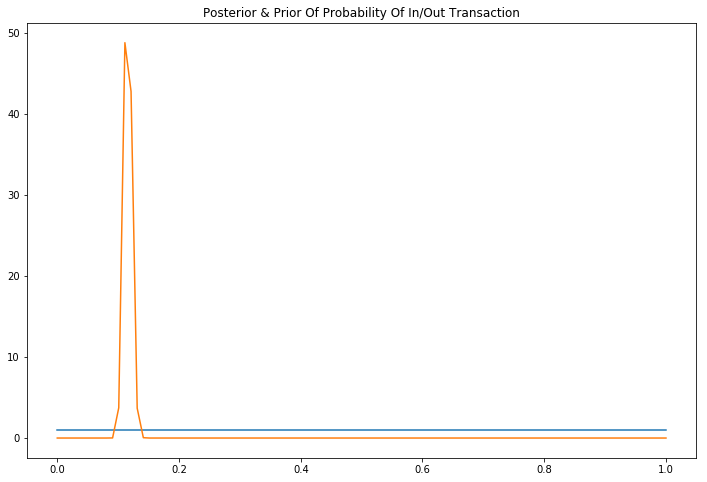

In [115]:
#Modeling in/out transaction probability for a day

#Count the number of in/out transaction
in_out = data['Amount'] > 0

data['In_Out'] = in_out

_in = data.loc[data['In_Out'] == True]['Day'].value_counts()
_out = data.loc[data['In_Out'] == False]['Day'].value_counts()

from scipy.stats import beta 

#Update a beta prior according to the conjugate property
a_prior = 1
b_prior = 1
a_post = a_prior + np.sum(_in)
b_post = b_prior + np.sum(_out)

prior = beta(a_prior, b_prior)
posterior = beta(a_post, b_post)

#Plot the prior and posterior
x_io = np.linspace(0,1,100)
y_io_1 = prior.pdf(x_io)
y_io_2 = posterior.pdf(x_io)

plt.figure(figsize=(12,8))
plt.plot(x_io,y_io_1, label='Prior')
plt.plot(x_io,y_io_2, label='Posterior')
plt.title('Posterior & Prior Of Probability Of In/Out Transaction')
plt.show()

In [128]:
#Creating fake transaction data for a month

def create_fake(month, date, size, in_out):
    #Sample the total number of transaction for the month
    n_trans = month.sample(1)
    
    #For each transaction, sample a date and a size for the transaction
    date_trans, size_trans = [], []
    for _ in range(int(n_trans)):
        _date = int(date.sample(1))
        if _date < 1: 
            _date = 1
        elif _date > 31:
            _date = 31
        date_trans.append(_date)
        size_trans.append(np.exp(size.sample(1))[0][0])
    
    #For the month, sample a proportion of that month transaction will be incoming
    p = in_out.rvs(size=1)
    for i in range(int(p*len(size_trans))):
        size_trans[i] = -size_trans[i]
    
    #Creating fake data
    d = {
        'Amount': size_trans,
        'Day': date_trans
    }
    fake_data = pd.DataFrame(data=d)
    
    return fake_data.sample(frac=1).reset_index(drop=True)

fake = create_fake(kde_1, kde_2, kde_3, posterior)
fake.head()

,Amount,Day
0,0.41,4
1,8.30,27
2,"4,293.39",10
3,"37,968.17",1
4,31.73,30


In [134]:
#Benford's Law
import math
def first_digit(num): 
    num = np.absolute(num)
    if num < 1: 
        return np.nan 
    else:
        num = str(num)
        return int(num[0])
digits = data['Amount'].apply(first_digit)

In [135]:
digits

0      5.00
1      5.00
2      5.00
3      5.00
4      5.00
5      5.00
6      4.00
7      4.00
8      4.00
9      4.00
10     4.00
11     4.00
12     4.00
13     4.00
14     4.00
15     4.00
16     4.00
17     4.00
18     4.00
19     4.00
20     4.00
21     4.00
22     4.00
23     4.00
24     4.00
25     4.00
26     4.00
27     4.00
28     4.00
29     4.00
       ... 
2488   1.00
2489   1.00
2490   1.00
2491   1.00
2492   1.00
2493   1.00
2494   2.00
2495   2.00
2496   2.00
2497   2.00
2498   2.00
2499   2.00
2500   2.00
2501   2.00
2502   2.00
2503   2.00
2504   2.00
2505   2.00
2506   2.00
2507   2.00
2508   2.00
2509   2.00
2510   2.00
2511   2.00
2512   2.00
2513   2.00
2514   2.00
2515   2.00
2516   3.00
2517   4.00
Name: Amount, Length: 2518, dtype: float64

In [132]:
plt.figure(figsize=(12,8))
plt.bar(digits.value_counts()/sum(digits.value_counts()))
plt.show()

TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 864x576 with 0 Axes>

In [84]:
month_data = data[data['Month-Year'] == '1_2016']

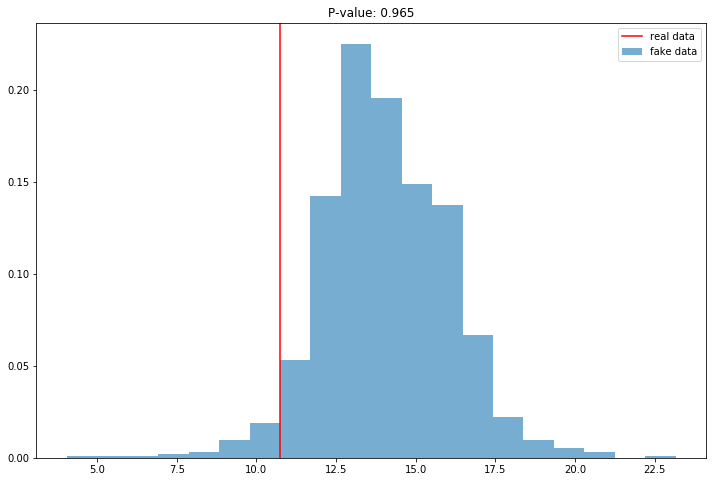

In [116]:
#Test statistics 

def test_stats_1(data): 
    return np.max(np.log(np.abs(data['Amount'])))

_test_stats = []
for _ in range(1000): 
    _fake = create_fake(kde_1, kde_2, kde_3, posterior)
    _test_stats.append(test_stats_1(_fake))

dumb = [_test_stats[i] > test_stats_1(month_data) for i in range(len(_test_stats))]

plt.figure(figsize=(12,8))
plt.hist(_test_stats, density=True, bins=20, alpha=0.6, label='fake data')
plt.axvline(test_stats_1(month_data), color='r', label='real data')
plt.legend()
plt.title('P-value: {}'.format(sum(dumb)/len(dumb)))
plt.show()

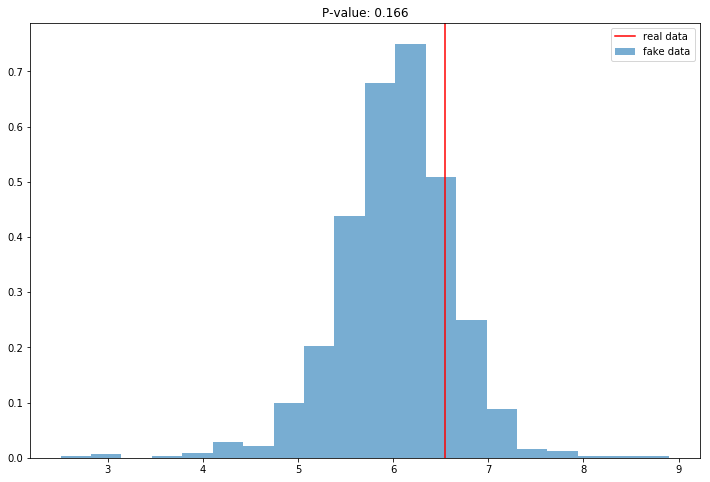

In [119]:
def test_stats_2(data): 
    return np.mean(np.log(np.abs(data['Amount'])))

_test_stats = []
for _ in range(1000): 
    _fake = create_fake(kde_1, kde_2, kde_3, posterior)
    _test_stats.append(test_stats_2(_fake))

dumb = [_test_stats[i] > test_stats_2(month_data) for i in range(len(_test_stats))]
plt.figure(figsize=(12,8))
plt.hist(_test_stats, density=True, bins=20, alpha=0.6, label='fake data')
plt.axvline(test_stats_2(month_data), color='r', label='real data')
plt.legend()
plt.title('P-value: {}'.format(sum(dumb)/len(dumb)))
plt.show()

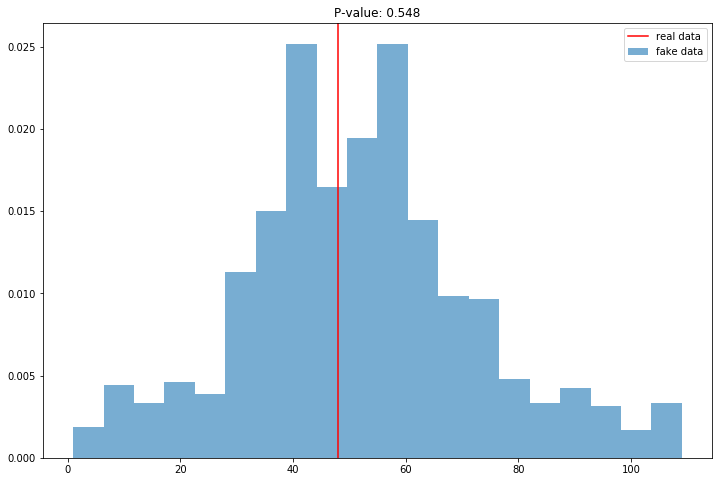

In [122]:
def test_stats_3(data): 
    return np.sum(data['Day'].value_counts())

_test_stats = []
for _ in range(1000): 
    _fake = create_fake(kde_1, kde_2, kde_3, posterior)
    _test_stats.append(test_stats_3(_fake))

dumb = [_test_stats[i] > test_stats_3(month_data) for i in range(len(_test_stats))]
plt.figure(figsize=(12,8))
plt.hist(_test_stats, density=True, bins=20, alpha=0.6, label='fake data')
plt.axvline(test_stats_3(month_data), color='r', label='real data')
plt.legend()
plt.title('P-value: {}'.format(sum(dumb)/len(dumb)))
plt.show()

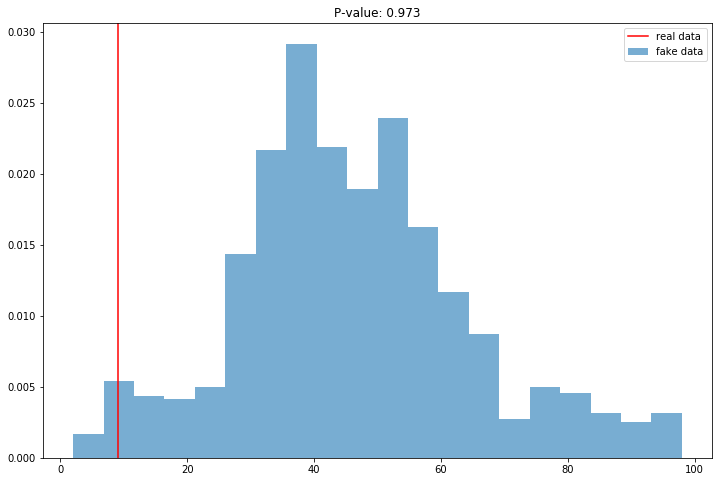

In [124]:
def test_stats_4(data):
    in_out = data['Amount'] > 0
    data['In_Out'] = in_out
    _in = data.loc[data['In_Out'] == True]['Day'].value_counts()
    return np.sum(_in)

_test_stats = []
for _ in range(1000): 
    _fake = create_fake(kde_1, kde_2, kde_3, posterior)
    _test_stats.append(test_stats_4(_fake))

dumb = [_test_stats[i] > test_stats_4(month_data) for i in range(len(_test_stats))]
plt.figure(figsize=(12,8))
plt.hist(_test_stats, density=True, bins=20, alpha=0.6, label='fake data')
plt.axvline(test_stats_4(month_data), color='r', label='real data')
plt.legend()
plt.title('P-value: {}'.format(sum(dumb)/len(dumb)))
plt.show()